In [1]:
import sys
sys.path.append("..")

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import importlib
import plotting

In [3]:
lf_z = lambda x: x**2
lf_theta = lambda x0, x1: x0*x1
loss_fn = lambda x0, x1: lf_z(lf_theta(x0, x1))

t1 = 10.
results = np.zeros((11, 11))
for t0_i, t0 in enumerate(np.linspace(0., 1., 11)):
    for eta_i, eta in enumerate(np.linspace(0., 0.02, 11)):
        g_T = float(jax.grad(lf_z)(t0*t1))
        k = t0/t1 + t1/t0
        g_beta = np.abs((1-eta**2*g_T**2)/(1+eta**2*g_T**2-k*eta*g_T))
        results[t0_i, eta_i] = g_beta



/tmp/ipykernel_6368/3413767349.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  k = t0/t1 + t1/t0
/tmp/ipykernel_6368/3413767349.py:11: RuntimeWarning: invalid value encountered in scalar multiply
  g_beta = np.abs((1-eta**2*g_T**2)/(1+eta**2*g_T**2-k*eta*g_T))


In [4]:
# exaggerated loss landscape (minimum in flat direction is very close)
lf_z = lambda x: x**2
lf_theta = lambda x0, x1: x0*x1
loss_fn = lambda x0, x1: lf_z(lf_theta(x0, x1))


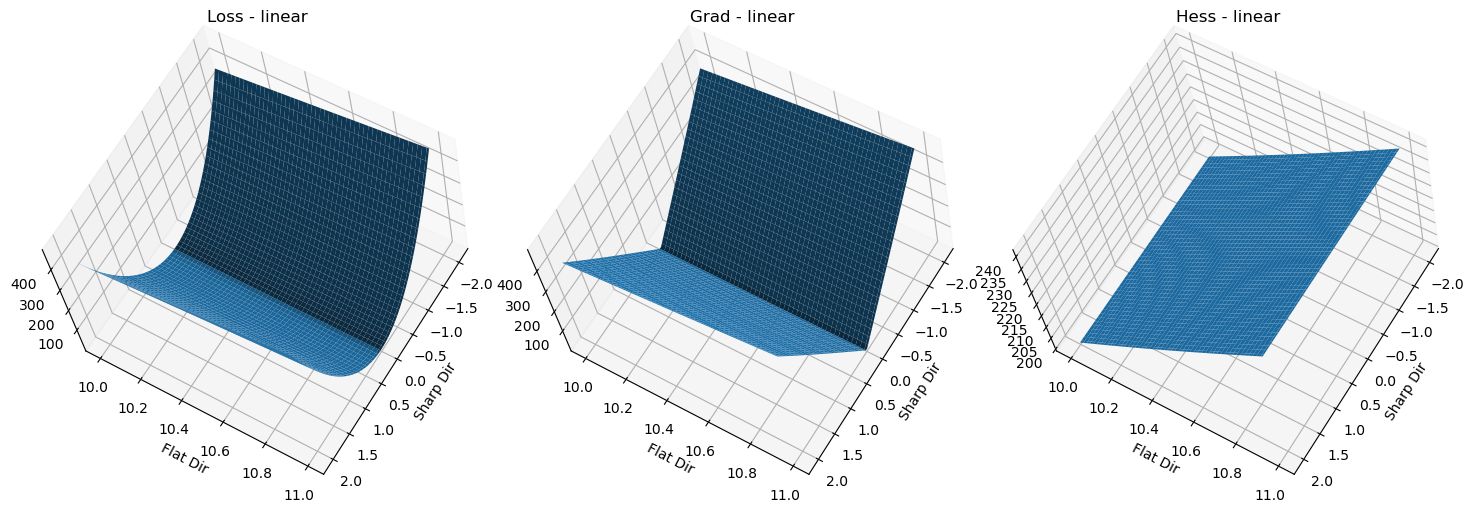

Grad, scaled by 9 for clarity
Eigvecs, scaled by 5 for clarity


(<Figure size 1454.55x480 with 3 Axes>,
 [<Axes3DSubplot: xlabel='Sharp Dir', ylabel='Flat Dir'>,
  <AxesSubplot: title={'center': 'Grad'}, xlabel='Sharp Dir', ylabel='Flat Dir'>,
  <AxesSubplot: title={'center': 'Eigvecs'}, xlabel='Sharp Dir', ylabel='Flat Dir'>])

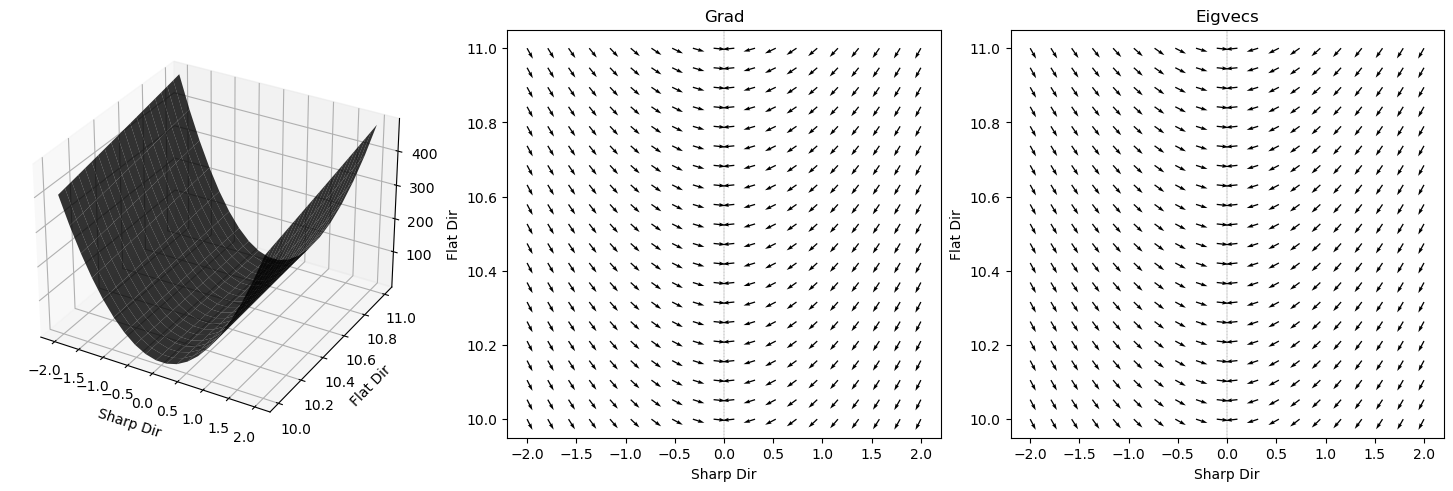

In [5]:
# exaggerated loss landscape
plotting.vis_landscape_lgh(loss_fn, ymin=10., ymax=11., scale='linear')
plotting.vis_landscape_lgh_q(loss_fn, ymin=10., ymax=11., scale='linear', yscale=True)

0.0 4.499999999999998 4.499999999999998 1.2507735946364105 1.002169364787675


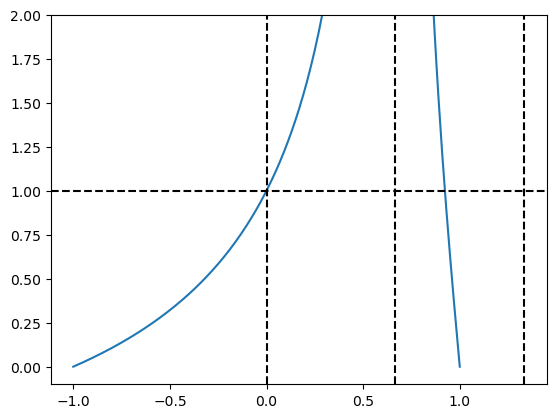

In [6]:
k = 1.5
fx = lambda x: np.abs((1-x**2)/(1-(k+1/k)*x+x**2))
xs = np.linspace(-1, 1, 201)
ys = fx(xs)
plt.plot(xs, ys)
ax = plt.gca()
ax.set_ylim(-0.1, 2)
ax.axhline(y=1, c='k', linestyle='--')
ax.axvline(x=0, c='k', linestyle='--')
ax.axvline(x=1/k, c='k', linestyle='--')
ax.axvline(x=2/k, c='k', linestyle='--')

print(fx(1), fx(0.5), fx(2), fx(9.9), fx(1000))


In [7]:
loss_fn = lambda x0, x1 : (x1)**2*(x0**2) # x0 first layer, x1 second layer


In [57]:
# realistic LL, opt trajectory
w0 = np.array([-0.1, 10.])

get_grad = lambda x, y: jax.grad(loss_fn, argnums=(0, 1))(x, y)
get_hess = lambda x, y: jax.hessian(loss_fn, argnums=(0, 1))(x, y)
    
etas = [0.001, 0.009, 0.011, 0.2]
# n_iters = [1000, 1000, 1000, 1000]
n_iters = [1000 for x in range(4)]
all_ws = []
all_sgs = []
all_shs = []
all_losses = []
all_gs = []
all_es = []
all_ss = []
rms_beta = 0.9
eps = 10**-8

for eta_i, eta in enumerate(etas):
    ws = [w0]
    grads = []
    sharps = []
    eigvs = []
    rms = np.array([0., 0.])
#     rms = None

    losses = []

    for i in range(n_iters[eta_i]):
        w_old = ws[-1]
        loss = loss_fn(w_old[0], w_old[1])
        losses.append(loss)
#         w_grad = np.array(jax.grad(loss_fn, argnums=(0, 1))(w_old[0], w_old[1]))
        w_grad = np.array(jax.jit(get_grad)(w_old[0], w_old[1]))
        grads.append(w_grad)
#         hess = np.array(jax.hessian(loss_fn, argnums=(0, 1))(w_old[0], w_old[1]))
        hess = np.array(jax.jit(get_hess)(w_old[0], w_old[1]))
        s, v = np.linalg.eigh(hess)
        sharps.append(s[1])
        eigvs.append(v[:, 1])
#         E[g²]t = βE[g²]t-1 + (1-β)gt²
#         if rms is None:
#             rms = w_grad**2
#         else:
        rms = rms_beta * rms + (1-rms_beta)*w_grad**2
        rms_eta = 20.* eta / np.sqrt(rms+eps)
    #     print(2/s[1], w_old, w_grad)
        w_new = w_old - rms_eta*w_grad # manually selected to be just above EoS with Sharp ~ 500000 so EoS ~ 0.000004
        ws.append(np.array(w_new))

    ws = np.array(ws)
    grads = np.array(grads)
    sharps = np.array(sharps)
    eigvs = np.array(eigvs)
    all_ws.append(ws)
    all_gs.append(grads)
    all_ss.append(sharps)
    all_es.append(eigvs)
    all_losses.append(losses)
    


Eigvecs, scaled by 0 for clarity


/tmp/ipykernel_2107367/3145868894.py:28: RuntimeWarning: divide by zero encountered in divide
  scaled_grads /= np.linalg.norm(scaled_grads, axis=1)[:, np.newaxis]
/tmp/ipykernel_2107367/3145868894.py:28: RuntimeWarning: invalid value encountered in divide
  scaled_grads /= np.linalg.norm(scaled_grads, axis=1)[:, np.newaxis]


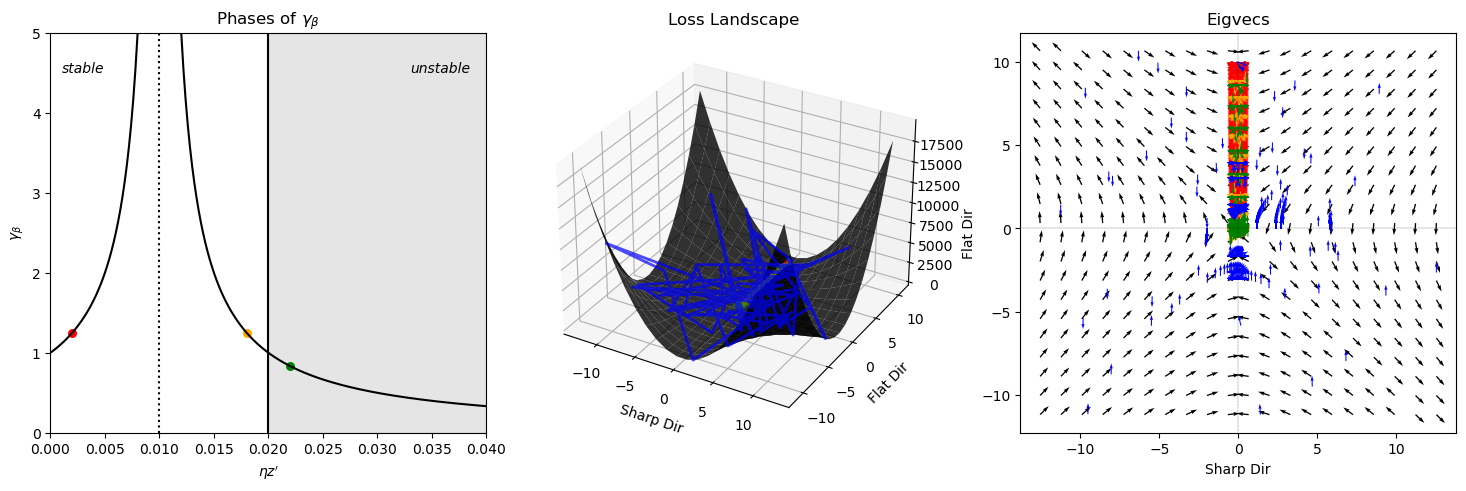

In [58]:
# realistic LL, opt trajectory
w0 = np.array([-0.1, 10.])

fig = plt.figure(figsize=plt.figaspect(0.33), layout='constrained')
# fig = plt.figure()
ax_b = fig.add_subplot(1, 3, 1,)
ax_l = fig.add_subplot(1, 3, 2, projection='3d', computed_zorder=False)
# ax_g = fig.add_subplot(1, 4, 3,)
ax_h = fig.add_subplot(1, 3, 3,)
axs = [ax_l, None, ax_h]
colors = ['r','orange',  'green', 'blue']
    
    # Realistic LL, quiver plot with steps in optim marked
importlib.reload(plotting)
xm = max(np.abs(np.min(ws[:, 0])), np.abs(np.max(ws[:, 0])))
fig, axs = plotting.vis_landscape_lgh_q(loss_fn, xmin=1.*-xm, xmax=1.*xm, 
                                        ymin=1.*np.min(ws[:, 1]), ymax=1.*np.max (ws[:, 1]), 
                                        yscale=True, fig=fig, axs=axs, do_g=False)

for i in range(len(etas)):
    ws = all_ws[i]
    losses = all_losses[i]
    
    sharp_scale, flat_scale = np.mean(np.abs(all_gs[-1]), axis=0)
    grad_scale = sharp_scale / flat_scale
    scaled_grads = all_gs[i].copy()
    scaled_grads[:, 1] *= grad_scale
    scaled_grads /= np.linalg.norm(scaled_grads, axis=1)[:, np.newaxis]

#     sharp_scale, flat_scale = np.mean(np.abs(all_es[-1]), axis=0)
#     hess_scale = sharp_scale / flat_scale
    hess_scale = 77
    scaled_hess = all_es[i].copy()
    scaled_hess[:, 1] *= hess_scale
    scaled_hess /= np.linalg.norm(scaled_hess, axis=1)[:, np.newaxis]
    scaled_hess *= np.sign(ws[:-1, 0])[:, np.newaxis]

    axs[0].plot(ws[:-1, 0], ws[:-1, 1], np.array(losses), c=colors[i], linewidth=2, alpha=0.7, zorder=1)
#     axs[1].quiver(ws[:-1, 0], ws[:-1, 1], -scaled_grads[:, 0], -scaled_grads[:, 1], color=colors[i], scale=20.)
    axs[2].quiver(ws[:-1, 0], ws[:-1, 1], scaled_hess[:, 0], scaled_hess[:, 1], color=colors[i], scale=40.)
    
k = 100.
fx = lambda x: np.abs((1-x**2)/(1-(k+1/k)*x+x**2))
xs = np.linspace(0., 0.04, 201)
ys = fx(xs)
# ax_g.remove()
ax_b.plot(xs, ys, c='k')
# ax = plt.gca()
ax_b.set_ylim(-0., 5)
ax_b.set_xlim(0.0, 0.04)
# ax_b.axhline(y=1, c='k', linestyle='dotted')
ax_b.fill_between(x=np.linspace(0, 1/k, 100), y1=0, y2=5, color='r', alpha=0.0)
ax_b.fill_between(x=np.linspace(1/k, 2/k, 100), y1=0, y2=5, color='r', alpha=0.0)
ax_b.fill_between(x=np.linspace(2/k, 0.04, 100), y1=0, y2=5, color='k', alpha=0.1)
ax_b.set_xlabel(r"$\eta z'$")
ax_b.set_ylabel(r"$\gamma_\beta$")

ax_b.axvline(x=1/k, c='k', linestyle='dotted')
ax_b.axvline(x=2/k, c='k', )

ax_l.set_title("Loss Landscape")
ax_b.set_title(r"Phases of $\gamma_\beta$")

ax_b.text(0.001, 4.5, 'stable', style='italic')
ax_b.text(0.033, 4.5, 'unstable', style='italic')

for eta_i, eta in enumerate(etas):
    this_x = eta*2
    ax_b.scatter(x=this_x, y=fx(this_x), c=colors[eta_i], marker='o', s=30)

plt.show()


[0.24999999] [1.] [0.24999999] [-1.]


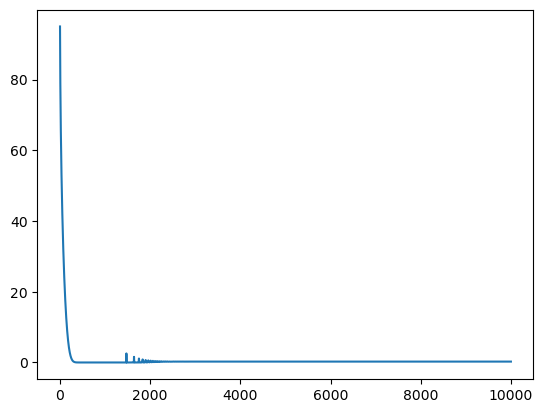

In [60]:
w0 = 100.
eta = 0.5
w = w0
rms_beta = 0.99
eps = 10**-8
# rms = np.array([4*w0**2])
rms = np.array([0.])
ws = []

for i in range(10000):
#     print(i, w)
    w_grad = 2*w
    rms = rms_beta * rms + (1-rms_beta)*w_grad**2
    rms_eta = 1.* eta / np.sqrt(rms+eps)
    w = w - rms_eta * w_grad
#     print(rms_eta, rms, w_grad**2, eta, eta/np.sqrt(rms+eps)) 
    ws.append(abs(w))
plt.plot(ws)
print(w, rms_eta, rms, w_grad/np.sqrt(rms))

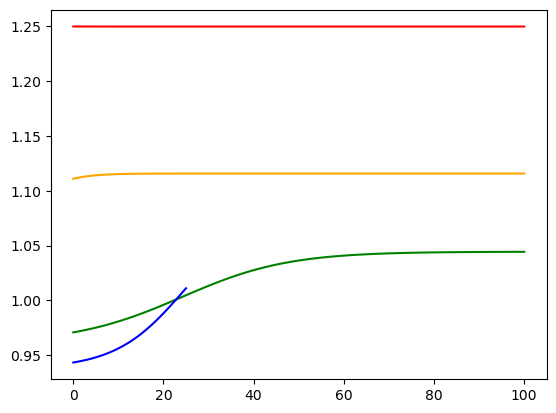

In [127]:
for i in range(len(etas)):
#     w = all_ws[i]
    eta = etas[i]
#     beta = np.abs(w[:, 0]**2-w[:, 1]**2)/np.abs((4*w[:, 0]*w[:, 1]))
#     R = beta + np.sqrt(beta**2+1)
    g_betas = []
    for t in range(len(all_ws[i])):
        w = all_ws[i][t]
        g_T = np.abs(2*w[0]*w[1])
        k = np.abs(w[0]/w[1]) + np.abs(w[1]/w[0])
        g_beta = np.abs((1-eta**2*g_T**2)/(1+eta**2*g_T**2-k*eta*g_T))
        g_betas.append(g_beta)
#         print(w, g_T, k, g_beta)
    plt.plot(g_betas, c=colors[i])
#     print(g_betas)

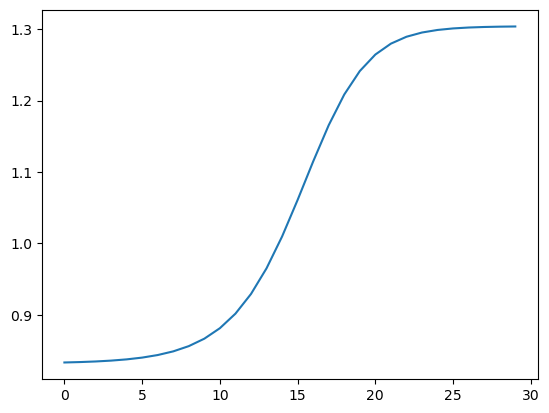

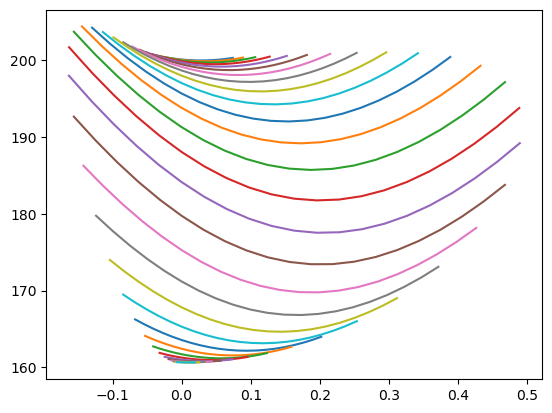

In [128]:
# realistic LL, opt trajectory
w0 = np.array([-0.1, 10.])

# fig = plt.figure(figsize=plt.figaspect(0.33), layout='constrained')
# # fig = plt.figure()
# ax_b = fig.add_subplot(1, 3, 1,)
# ax_l = fig.add_subplot(1, 3, 2, projection='3d', computed_zorder=False)
# # ax_g = fig.add_subplot(1, 4, 3,)
# ax_h = fig.add_subplot(1, 3, 3,)
# axs = [ax_l, ax_g, ax_h]
# etas = [0.0099, 0.001, 0.0102]
# etas = [0.0102, 0.011, 0.015]
# n_iters = [70, 50, 13]
# n_iters = [100, 100, 100]
etas = [0.011]
n_iters = [30]
colors = ['green', 'r', 'blue']
all_ws = []
all_sgs = []
all_shs = []
all_losses = []
all_gs = []
all_es = []
all_ss = []

for eta_i, eta in enumerate(etas):
    ws = [w0]
    grads = []
    sharps = []
    eigvs = []
    gbs = []
    losses = []

    for i in range(n_iters[eta_i]):
        w_old = ws[-1]
        loss = loss_fn(w_old[0], w_old[1])
        losses.append(loss)
        w_grad = np.array(jax.grad(loss_fn, argnums=(0, 1))(w_old[0], w_old[1]))
        grads.append(w_grad)
        hess = np.array(jax.hessian(loss_fn, argnums=(0, 1))(w_old[0], w_old[1]))
        s, v = np.linalg.eigh(hess)
        sharps.append(s[1])
        eigvs.append(v[:, 1])
    #     print(2/s[1], w_old, w_grad)
        w_new = w_old - eta*w_grad # manually selected to be just above EoS with Sharp ~ 500000 so EoS ~ 0.000004
        ws.append(np.array(w_new))
        t0, t1 = w_old
        g_T = float(2*t0*t1)
        k = t0/t1 + t1/t0
        g_beta = np.abs((1-eta**2*g_T**2)/(1+eta**2*g_T**2-k*eta*g_T))
        gbs.append(g_beta)
    ws = np.array(ws)
    grads = np.array(grads)
    sharps = np.array(sharps)
    eigvs = np.array(eigvs)
    gbs = np.array(gbs)
    plt.plot(gbs)
    plt.show()
    
    grad_scale = np.max(np.linalg.norm(grads[:30]), axis=0)
    for i in range(30):
        grad_range = np.linspace(-0.5, 1.5, 21)
        plt_xs = np.array([-x*grads[i]*eta + ws[i] for x in grad_range])
        def get_y(x):
            hess = np.array(jax.hessian(loss_fn, argnums=(0, 1))(x[0], x[1]))
            s, v = np.linalg.eigh(hess)
            return max(s)
        
        plt_ys = [get_y(x) for x in plt_xs]
#         plt_xs /= grad_scale
        plt.plot(grad_range*np.linalg.norm(grads[i])/grad_scale, plt_ys)
    ax = plt.gca()
#     ax.set_yscale('log')
    

In [129]:
print(grads.shape)

(30, 2)


In [ ]:
# quartic is too high order

In [52]:
loss_fn = lambda x0, x1 : (x1)**4*(x0)**4 # x0 first layer, x1 second layer


[1.2002133e+03 1.1992532e+03 1.1944624e+03 1.1707461e+03 1.0577832e+03
 6.1489105e+02 3.7576976e-01 3.7529925e-01 3.7482992e-01 3.7436169e-01
 3.7389469e-01 3.7342888e-01 3.7296414e-01]


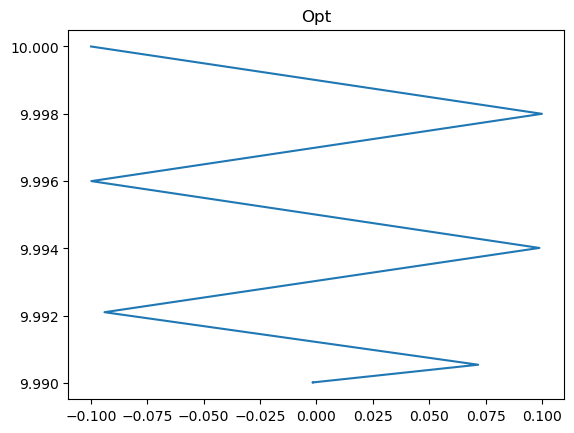

In [70]:
w0 = np.array([-0.1, 10.])

eta = 0.005
ws = [w0]
grads = []
sharps = []
eigvs = []

losses = []

for i in range(n_iters[eta_i]):
    w_old = ws[-1]
    loss = loss_fn(w_old[0], w_old[1])
    losses.append(loss)
    w_grad = np.array(jax.grad(loss_fn, argnums=(0, 1))(w_old[0], w_old[1]))
    grads.append(w_grad)
    hess = np.array(jax.hessian(loss_fn, argnums=(0, 1))(w_old[0], w_old[1]))
    s, v = np.linalg.eigh(hess)
    sharps.append(s[1])
    eigvs.append(v[:, 1])
#     print(2/s[1], w_old, w_grad)
    w_new = w_old - eta*w_grad # manually selected to be just above EoS with Sharp ~ 500000 so EoS ~ 0.000004
    ws.append(np.array(w_new))

ws = np.array(ws)
grads = np.array(grads)
sharps = np.array(sharps)
eigvs = np.array(eigvs)
print(sharps)
fig, ax = plt.subplots(1, 1)
ax.plot(ws[:, 0], ws[:, 1])
ax.set_title("Opt")
plt.show()


Eigvecs, scaled by 142 for clarity


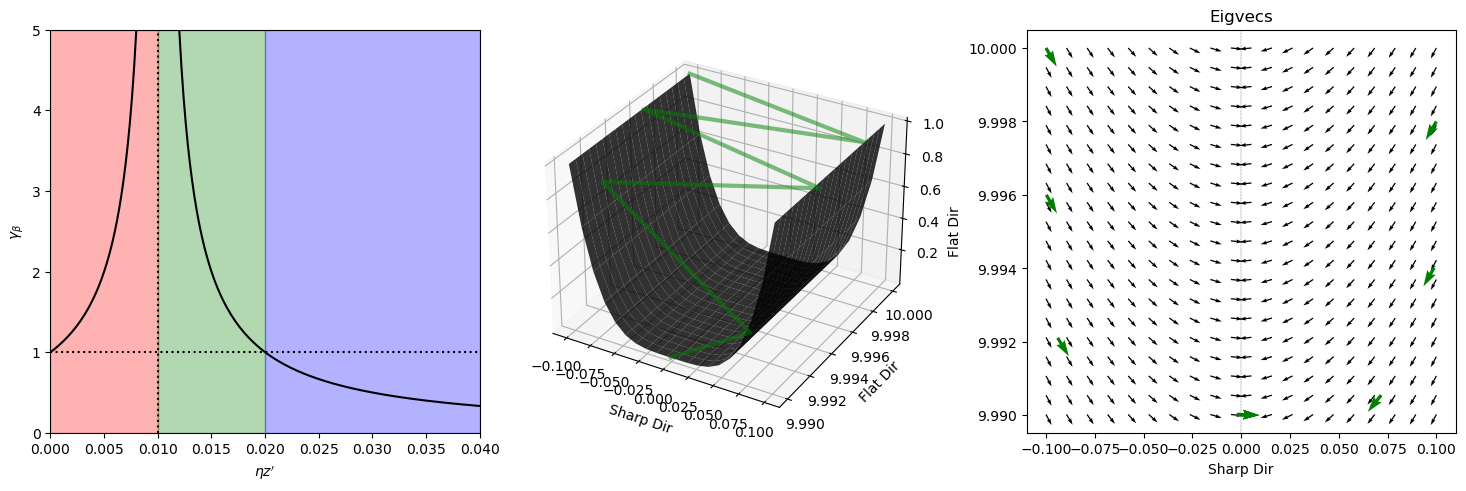

In [71]:
# realistic LL, opt trajectory
w0 = np.array([-0.1, 10.])

fig = plt.figure(figsize=plt.figaspect(0.33), layout='constrained')
# fig = plt.figure()
ax_b = fig.add_subplot(1, 3, 1,)
ax_l = fig.add_subplot(1, 3, 2, projection='3d', computed_zorder=False)
# ax_g = fig.add_subplot(1, 4, 3,)
ax_h = fig.add_subplot(1, 3, 3,)
axs = [ax_l, ax_g, ax_h]
# etas = [0.0099, 0.001, 0.0102]
# n_iters = [70, 50, 13]
etas = [0.005]
n_iters = [10]
colors = ['green', 'r', 'blue']
all_ws = []
all_sgs = []
all_shs = []
all_losses = []
all_gs = []
all_es = []
all_ss = []

for eta_i, eta in enumerate(etas):
    ws = [w0]
    grads = []
    sharps = []
    eigvs = []
# eta = 0.0099
# eta = 0.001
# eta = 0.0105

    losses = []

    for i in range(n_iters[eta_i]):
        w_old = ws[-1]
        loss = loss_fn(w_old[0], w_old[1])
        losses.append(loss)
        w_grad = np.array(jax.grad(loss_fn, argnums=(0, 1))(w_old[0], w_old[1]))
        grads.append(w_grad)
        hess = np.array(jax.hessian(loss_fn, argnums=(0, 1))(w_old[0], w_old[1]))
        s, v = np.linalg.eigh(hess)
        sharps.append(s[1])
        eigvs.append(v[:, 1])
    #     print(2/s[1], w_old, w_grad)
        w_new = w_old - eta*w_grad # manually selected to be just above EoS with Sharp ~ 500000 so EoS ~ 0.000004
        ws.append(np.array(w_new))

    ws = np.array(ws)
    grads = np.array(grads)
    sharps = np.array(sharps)
    eigvs = np.array(eigvs)
    all_ws.append(ws)
    all_gs.append(grads)
    all_ss.append(sharps)
    all_es.append(eigvs)
    all_losses.append(losses)
    
    # Realistic LL, quiver plot with steps in optim marked
importlib.reload(plotting)
xm = max(np.abs(np.min(ws[:, 0])), np.abs(np.max(ws[:, 0])))
fig, axs = plotting.vis_landscape_lgh_q(loss_fn, xmin=1.*-xm, xmax=1.*xm, 
                                        ymin=1.*np.min(ws[:, 1]), ymax=1.*np.max (ws[:, 1]), 
                                        yscale=True, fig=fig, axs=axs, do_g=False)

for i in range(len(etas)):
    ws = all_ws[i]
    losses = all_losses[i]
    
    sharp_scale, flat_scale = np.mean(np.abs(all_gs[-1]), axis=0)
    grad_scale = sharp_scale / flat_scale
    scaled_grads = all_gs[i].copy()
    scaled_grads[:, 1] *= grad_scale
    scaled_grads /= np.linalg.norm(scaled_grads, axis=1)[:, np.newaxis]

    sharp_scale, flat_scale = np.mean(np.abs(all_es[-1]), axis=0)
    hess_scale = sharp_scale / flat_scale
    scaled_hess = all_es[i].copy()
    scaled_hess[:, 1] *= hess_scale
    scaled_hess /= np.linalg.norm(scaled_hess, axis=1)[:, np.newaxis]
    scaled_hess *= np.sign(ws[:-1, 0])[:, np.newaxis]

    axs[0].plot(ws[:-1, 0], ws[:-1, 1], np.array(losses), c=colors[i], linewidth=3, alpha=0.5, zorder=1)
#     axs[1].quiver(ws[:-1, 0], ws[:-1, 1], -scaled_grads[:, 0], -scaled_grads[:, 1], color=colors[i], scale=20.)
    axs[2].quiver(ws[:-1, 0], ws[:-1, 1], scaled_hess[:, 0], scaled_hess[:, 1], color=colors[i], scale=20.)
k = 100.
fx = lambda x: np.abs((1-x**2)/(1-(k+1/k)*x+x**2))
xs = np.linspace(0., 0.04, 201)
ys = fx(xs)
# ax_g.remove()
ax_b.plot(xs, ys, c='k')
# ax = plt.gca()
ax_b.set_ylim(-0., 5)
ax_b.set_xlim(0.0, 0.04)
ax_b.axhline(y=1, c='k', linestyle='dotted')
ax_b.fill_between(x=np.linspace(0, 1/k, 100), y1=0, y2=5, color='r', alpha=0.3)
ax_b.fill_between(x=np.linspace(1/k, 2/k, 100), y1=0, y2=5, color='g', alpha=0.3)
ax_b.fill_between(x=np.linspace(2/k, 0.04, 100), y1=0, y2=5, color='b', alpha=0.3)
ax_b.set_xlabel(r"$\eta z'$")
ax_b.set_ylabel(r"$\gamma_\beta$")

# ax.axvline(x=0, c='k', linestyle='--')
ax_b.axvline(x=1/k, c='k', linestyle='dotted')
# ax.axvline(x=2/k, c='k', linestyle='--')
# fig.delaxes(ax_g)
# ax_b.change_geometry(1,3,1)
# ax_l.change_geometry(1,3,2)
# ax_h.change_geometry(1,3,3)

# plt.draw()
# plt.tight_layout()
# print(fx(1), fx(0.5), fx(2), fx(9.9), fx(1000))
plt.show()
# print(np.min(ws[:, 1]))